In [1]:
import numpy as np

from PIL import Image
from torch.utils.data import Dataset

def load_voice(voice_item):
    voice_data = np.load(voice_item['filepath'])
    voice_data = voice_data.T.astype('float32')
    voice_label = voice_item['label_id']
    print("Loading voice data: ", voice_data, voice_label)
    return voice_data, voice_label

def load_face(face_item):
    face_data = Image.open(face_item['filepath']).convert('RGB').resize([64, 64])
    face_data = np.transpose(np.array(face_data), (2, 0, 1))
    face_data = ((face_data - 127.5) / 127.5).astype('float32')
    face_label = face_item['label_id']
    print("Loading face data: ", face_data, face_label)
    return face_data, face_label

class VoiceDataset(Dataset):
    def __init__(self, voice_list, nframe_range):
        self.voice_list = voice_list
        self.crop_nframe = nframe_range[1]

    def __getitem__(self, index):
        voice_data, voice_label = load_voice(self.voice_list[index])
        assert self.crop_nframe <= voice_data.shape[1]
        pt = np.random.randint(voice_data.shape[1] - self.crop_nframe + 1)
        voice_data = voice_data[:, pt:pt+self.crop_nframe]
        return voice_data, voice_label

    def __len__(self):
        return len(self.voice_list)

class FaceDataset(Dataset):
    def __init__(self, face_list):
        self.face_list = face_list

    def __getitem__(self, index):
        face_data, face_label = load_face(self.face_list[index])
        if np.random.random() > 0.5:
           face_data = np.flip(face_data, axis=2).copy()
        return face_data, face_label

    def __len__(self):
        return len(self.face_list)


c:\Users\Ahmed\.conda\envs\tensorflow-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import string
from dataset import VoiceDataset, FaceDataset
from network import VoiceEmbedNet, Generator, FaceEmbedNet, Classifier
from utils import get_collate_fn

DATASET_PARAMETERS = {
    # meta data provided by voxceleb1 dataset
    'meta_file': 'voxCeleb-Dataset\\vox1_meta_m.csv',

    # voice dataset
    'voice_dir': 'voxCeleb-Dataset\\males\\voices',
    'voice_ext': 'npy',

    # face dataset
    'face_dir': 'voxCeleb-Dataset\\males\\faces',
    'face_ext': '.jpg',

    # train data includes the identities
    # whose names start with the characters of 'FGH...XYZ'
    'split': string.ascii_uppercase[5:],

    # dataloader
    'voice_dataset': VoiceDataset,
    'face_dataset': FaceDataset,
    'batch_size': 128,
    'nframe_range': [300, 800],
    'workers_num': 1,
    'collate_fn': get_collate_fn,

    # test data
    'test_data': 'data\\example_data'
}


NETWORKS_PARAMETERS = {
    # VOICE EMBEDDING NETWORK (e)
    'e': {
        'network': VoiceEmbedNet,
        'input_channel': 64,
        'channels': [256, 384, 576, 864],
        'output_channel': 64,  # the embedding dimension
        'model_path': 'pretrained_models/voice_embedding.pth',
    },
    # GENERATOR (g)
    'g': {
        'network': Generator,
        'input_channel': 64,
        # channels for deconvolutional layers
        'channels': [1024, 512, 256, 128, 64],
        'output_channel': 3,  # images with RGB channels
        'model_path': 'models\\males_models\\generator.pth',
    },
    # FACE EMBEDDING NETWORK (f)
    'f': {
        'network': FaceEmbedNet,
        'input_channel': 3,
        'channels': [32, 64, 128, 256, 512],
        'output_channel': 64,
        'model_path': 'models\\males_models\\face_embedding.pth',
    },
    # DISCRIMINATOR (d)
    'd': {
        'network': Classifier,  # Discrminator is a special Classifier with 1 subject
        'input_channel': 64,
        'channels': [],
        'output_channel': 1,
        'model_path': 'models\\males_models\\discriminator.pth',
    },
    # CLASSIFIER (c)
    'c': {
        'network': Classifier,
        'input_channel': 64,
        'channels': [],
        'output_channel': -1,  # This parameter is depended on the dataset we used
        'model_path': 'models\\males_models\\classifier.pth',
    },
    # OPTIMIZER PARAMETERS
    'lr': 0.0002,
    'beta1': 0.5,
    'beta2': 0.999,

    # MODE, use GPU or not
    'GPU': True


}


In [3]:
import os

def parse_metafile(meta_file):
    with open(meta_file, 'r') as f:
        lines = f.readlines()[1:]
    celeb_ids = {}
    for line in lines:
        ID, name, _, _, _ = line.rstrip().split(',')
        celeb_ids[ID] = name
    return celeb_ids

def get_labels(voice_list, face_list):
    voice_names = {item['name'] for item in voice_list}
    face_names = {item['name'] for item in face_list}
    names = voice_names & face_names

    voice_list = [item for item in voice_list if item['name'] in names]
    face_list = [item for item in face_list if item['name'] in names]

    names = sorted(list(names))
    label_dict = dict(zip(names, range(len(names))))
    for item in voice_list+face_list:
        item['label_id'] = label_dict[item['name']]
    return voice_list, face_list, len(names)
    

def get_dataset_files(data_dir, data_ext, celeb_ids, split):
    data_list = []
    # read data directory
    for root, dirs, filenames in os.walk(data_dir):
        for filename in filenames:
            if filename.endswith(data_ext):
                filepath = os.path.join(root, filename)
                # so hacky, be careful! 
                folder = filepath[len(data_dir):].split('\\')[1]
                celeb_name = celeb_ids.get(folder, folder)
                if celeb_name.startswith(tuple(split)):
                    data_list.append({'filepath': filepath, 'name': celeb_name})
    return data_list

def get_dataset(data_params):
    celeb_ids = parse_metafile(data_params['meta_file'])
    
    voice_list = get_dataset_files(data_params['voice_dir'],
                                   data_params['voice_ext'],
                                   celeb_ids,
                                   data_params['split'])
    face_list = get_dataset_files(data_params['face_dir'],
                                  data_params['face_ext'],
                                  celeb_ids,
                                  data_params['split'])
    return get_labels(voice_list, face_list)



In [4]:
# dataset and dataloader
print('Parsing your dataset...')
voice_list, face_list, id_class_num = get_dataset(DATASET_PARAMETERS)
print("voice",voice_list[0],len(voice_list))
print("face",face_list[0],len(face_list))
print("id_class_num",id_class_num)
NETWORKS_PARAMETERS['c']['output_channel'] = id_class_num

Parsing your dataset...
voice {'filepath': 'voxCeleb-Dataset\\males\\voices\\id10312\\0aOZh1TsKe0\\00001.npy', 'name': 'Fawad_Khan', 'label_id': 0} 63023
face {'filepath': 'voxCeleb-Dataset\\males\\faces\\Fawad_Khan\\00000001.jpg', 'name': 'Fawad_Khan', 'label_id': 0} 55009
id_class_num 485


In [5]:
print('Preparing the datasets...')
voice_dataset = DATASET_PARAMETERS['voice_dataset'](voice_list,DATASET_PARAMETERS['nframe_range'])
face_dataset = DATASET_PARAMETERS['face_dataset'](face_list)

Preparing the datasets...


In [6]:
import os
import time
import torch
import torch.nn.functional as F

from torch.utils.data import DataLoader
from network import get_network
from utils import Meter, cycle, save_model


In [7]:
print('Preparing the dataloaders...')
collate_fn = DATASET_PARAMETERS['collate_fn'](DATASET_PARAMETERS['nframe_range'])
voice_loader = DataLoader(voice_dataset, shuffle=True, drop_last=True,
                          batch_size=DATASET_PARAMETERS['batch_size'],
                          num_workers=DATASET_PARAMETERS['workers_num']
                          )
face_loader = DataLoader(face_dataset, shuffle=True, drop_last=True,
                         batch_size=DATASET_PARAMETERS['batch_size'],
                         num_workers=DATASET_PARAMETERS['workers_num'])

Preparing the dataloaders...


In [8]:
voice_iterator = iter(cycle(voice_loader))
face_iterator = iter(cycle(face_loader))

In [9]:
device = torch.device("cuda")
device

device(type='cuda')

In [13]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class VoiceEmbedNet(nn.Module):
    def __init__(self, input_channel, channels, output_channel):
        super(VoiceEmbedNet, self).__init__()
        self.model = nn.Sequential(
            nn.Conv1d(input_channel, channels[0], 3, 2, 1, bias=False),
            nn.BatchNorm1d(channels[0], affine=True),
            nn.ReLU(inplace=True),
            nn.Conv1d(channels[0], channels[1], 3, 2, 1, bias=False),
            nn.BatchNorm1d(channels[1], affine=True),
            nn.ReLU(inplace=True),
            nn.Conv1d(channels[1], channels[2], 3, 2, 1, bias=False),
            nn.BatchNorm1d(channels[2], affine=True),
            nn.ReLU(inplace=True),
            nn.Conv1d(channels[2], channels[3], 3, 2, 1, bias=False),
            nn.BatchNorm1d(channels[3], affine=True),
            nn.ReLU(inplace=True),
            nn.Conv1d(channels[3], output_channel, 3, 2, 1, bias=True),
        )

    def forward(self, x):
        x = self.model(x)
        x = F.avg_pool1d(x, x.size()[2], stride=1)
        x = x.view(x.size()[0], -1, 1, 1)
        return x

class Generator(nn.Module):
    def __init__(self, input_channel, channels, output_channel):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(input_channel, channels[0], 4, 1, 0, bias=True),
            nn.BatchNorm1d(channels[0], affine=True),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(channels[0], channels[1], 4, 2, 1, bias=True),
            nn.BatchNorm1d(channels[1], affine=True),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(channels[1], channels[2], 4, 2, 1, bias=True),
            nn.BatchNorm1d(channels[2], affine=True),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(channels[2], channels[3], 4, 2, 1, bias=True),
            nn.BatchNorm1d(channels[3], affine=True),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(channels[3], channels[4], 4, 2, 1, bias=True),
            nn.BatchNorm1d(channels[4], affine=True),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(channels[4], output_channel, 1, 1, 0, bias=True),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.model(x)
        return x

class FaceEmbedNet(nn.Module):
    def __init__(self, input_channel, channels, output_channel):
        super(FaceEmbedNet, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_channel, channels[0], 1, 1, 0, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(channels[0], channels[1], 4, 2, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(channels[1], channels[2], 4, 2, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(channels[2], channels[3], 4, 2, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(channels[3], channels[4], 4, 2, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(channels[4], output_channel, 4, 1, 0, bias=True),
        )
 
    def forward(self, x):
        x = self.model(x)
        return x

class Classifier(nn.Module):
    def __init__(self, input_channel, channels, output_channel):
        super(Classifier, self).__init__()
        self.model = nn.Linear(input_channel, output_channel, bias=False)

    def forward(self, x):
        x = x.view(x.size()[0], -1)
        x = self.model(x)
        return x

def get_network(net_type, params, train=True):
    net_params = params[net_type]
    net = net_params['network'](net_params['input_channel'],
                                net_params['channels'],
                                net_params['output_channel'])

    if params['GPU']:
        net.cuda()

    if train:
        #if net_params['model_path'] is not None:
        #    print('load model from {}'.format(net_params['model_path']))
        #    net.load_state_dict(torch.load(net_params['model_path'],map_location=torch.device('cpu')))
        net.train()
        optimizer = optim.RMSprop(net.parameters(),lr=params['lr'],alpha=0.9,eps=1e-08,weight_decay=0, momentum=0, centered=False)
        #optimizer = optim.Adam(net.parameters(), lr=params['lr'], betas=(params['beta1'], params['beta2']))
    else:
        net.eval()
        net.load_state_dict(torch.load(net_params['model_path'],map_location=torch.device('cpu')))
        optimizer = None
        
    return net, optimizer


In [14]:
torch.cuda.is_available()

True

In [15]:
# networks, Fe, Fg, Fd (f+d), Fc (f+c)
print('Initializing networks...')
e_net, e_optimizer = get_network('e', NETWORKS_PARAMETERS, train=False) #voice embed
g_net, g_optimizer = get_network('g', NETWORKS_PARAMETERS, train=True) #generator
f_net, f_optimizer = get_network('f', NETWORKS_PARAMETERS, train=True) #face embed
d_net, d_optimizer = get_network('d', NETWORKS_PARAMETERS, train=True) #discriminator
c_net, c_optimizer = get_network('c', NETWORKS_PARAMETERS, train=True) #classifier

Initializing networks...


In [16]:
# label for real/fake faces
real_label = torch.full((DATASET_PARAMETERS['batch_size'], 1), 1)
fake_label = torch.full((DATASET_PARAMETERS['batch_size'], 1), 0)


In [17]:
# Meters for recording the training status
iteration = Meter('Iter', 'sum', ':5d')
data_time = Meter('Data', 'sum', ':4.2f')
batch_time = Meter('Time', 'sum', ':4.2f')
D_real = Meter('D_real', 'avg', ':3.2f')
D_fake = Meter('D_fake', 'avg', ':3.2f')
C_real = Meter('C_real', 'avg', ':3.2f')
GD_fake = Meter('G_D_fake', 'avg', ':3.2f')
GC_fake = Meter('G_C_fake', 'avg', ':3.2f')

In [18]:
generator_losses = []
discriminator_losses = []
x_axis = []
times = []

In [19]:
import pandas as pd

dict = {'Epoch': x_axis, 'Generator loss': generator_losses, 'Discriminator loss': discriminator_losses}
df = pd.DataFrame(dict)
df

,Epoch,Generator loss,Discriminator loss


In [28]:
print('Training models...')
for it in range(2000):
    # data
    start_time = time.time()
    
    x_axis.append(it)
    
    voice, voice_label = next(voice_iterator)
    face, face_label = next(face_iterator)
    noise = 0.05*torch.randn(DATASET_PARAMETERS['batch_size'], 64, 1, 1)

    # use GPU or not
    
    if NETWORKS_PARAMETERS['GPU']: 
        voice, voice_label = voice.cuda(), voice_label.cuda()
        face, face_label = face.cuda(), face_label.cuda()
        real_label, fake_label = real_label.cuda(), fake_label.cuda()
        noise = noise.cuda()
    data_time.update(time.time() - start_time)
    
    # get embeddings and generated faces
    embeddings = e_net(voice)
    embeddings = F.normalize(embeddings)
    # introduce some permutations
    embeddings = embeddings + noise
    embeddings = F.normalize(embeddings)
    fake = g_net(embeddings)

    # Discriminator
    f_optimizer.zero_grad()
    d_optimizer.zero_grad()
    c_optimizer.zero_grad()
    real_score_out = d_net(f_net(face))
    fake_score_out = d_net(f_net(fake.detach()))
    real_label_out = c_net(f_net(face))
    D_real_loss = F.binary_cross_entropy(torch.sigmoid(real_score_out), real_label.type(torch.cuda.FloatTensor))
    D_fake_loss = F.binary_cross_entropy(torch.sigmoid(fake_score_out), fake_label.type(torch.cuda.FloatTensor))
    C_real_loss = F.nll_loss(F.log_softmax(real_label_out, 1), face_label)
    D_real.update(D_real_loss.item())
    D_fake.update(D_fake_loss.item())
    C_real.update(C_real_loss.item())
    
    discriminator_losses.append((D_real_loss + D_fake_loss + C_real_loss).item())
    
    (D_real_loss + D_fake_loss + C_real_loss).backward()
    f_optimizer.step()
    d_optimizer.step()
    c_optimizer.step()

    # Generator
    g_optimizer.zero_grad()
    fake_score_out = d_net(f_net(fake))
    fake_label_out = c_net(f_net(fake))
    GD_fake_loss = F.binary_cross_entropy(torch.sigmoid(fake_score_out), real_label.type(torch.cuda.FloatTensor))
    GC_fake_loss = F.nll_loss(F.log_softmax(fake_label_out, 1), voice_label)
    
    generator_losses.append((GD_fake_loss + GC_fake_loss).item())
    
    (GD_fake_loss + GC_fake_loss).backward()
    GD_fake.update(GD_fake_loss.item())
    GC_fake.update(GC_fake_loss.item())
    g_optimizer.step()

    times.append(time.time() - start_time)
    
    batch_time.update(time.time() - start_time)
    df = pd.DataFrame({'Epoch': x_axis,'Generator loss': generator_losses, 'Discriminator loss': discriminator_losses})
    # print status
    if it % 10 == 0:
        print(iteration, data_time, batch_time,D_real, D_fake, C_real, GD_fake, GC_fake)
        data_time.reset()
        batch_time.reset()
        D_real.reset()
        D_fake.reset()
        C_real.reset()
        GD_fake.reset()
        GC_fake.reset()
        # snapshot
        save_model(g_net, NETWORKS_PARAMETERS['g']['model_path'])
        save_model(f_net, NETWORKS_PARAMETERS['f']['model_path'])
        save_model(d_net, NETWORKS_PARAMETERS['d']['model_path'])
        save_model(c_net, NETWORKS_PARAMETERS['c']['model_path'])
        df.to_csv('loss_m.csv', index=False, header=True)
    iteration.update(1)

Training models...
Iter: 2000, Data:77.50, Time:88.27, D_real:0.64, D_fake:0.57, C_real:2.27, G_D_fake:1.94, G_C_fake:2.42,
Iter: 2010, Data:170.17, Time:181.15, D_real:0.19, D_fake:0.13, C_real:2.15, G_D_fake:2.93, G_C_fake:2.36,
Iter: 2020, Data:120.93, Time:131.64, D_real:0.12, D_fake:0.08, C_real:2.19, G_D_fake:3.80, G_C_fake:2.47,
Iter: 2030, Data:111.11, Time:121.73, D_real:0.07, D_fake:0.03, C_real:2.30, G_D_fake:4.23, G_C_fake:2.64,
Iter: 2040, Data:80.06, Time:90.74, D_real:0.05, D_fake:0.03, C_real:2.25, G_D_fake:4.58, G_C_fake:2.72,
Iter: 2050, Data:103.59, Time:114.32, D_real:0.06, D_fake:0.03, C_real:2.21, G_D_fake:5.09, G_C_fake:2.65,
Iter: 2060, Data:129.02, Time:139.73, D_real:0.04, D_fake:0.02, C_real:2.12, G_D_fake:5.22, G_C_fake:2.68,
Iter: 2070, Data:123.34, Time:134.15, D_real:0.03, D_fake:0.01, C_real:2.13, G_D_fake:5.49, G_C_fake:2.65,
Iter: 2080, Data:138.82, Time:149.75, D_real:0.03, D_fake:0.01, C_real:2.12, G_D_fake:5.70, G_C_fake:2.72,
Iter: 2090, Data:126.1

In [18]:
#print(generator_losses)
#print(discriminator_losses)
#print(x_axis)
#print(times)

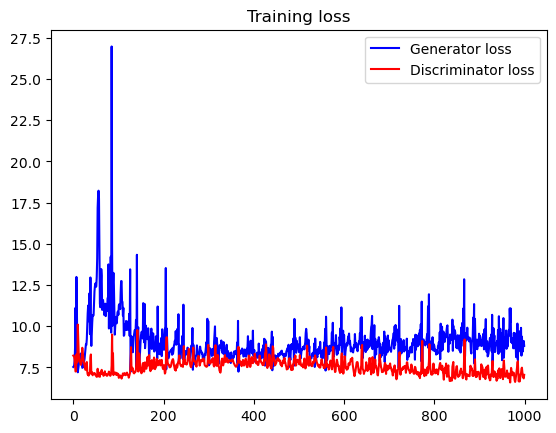

In [21]:
epochs = range(1, len(x_axis) + 1)
import matplotlib.pyplot as plt
df = pd.read_csv('loss.csv')
plt.plot(df["Epoch"], df["Generator loss"], 'b', label='Generator loss')
plt.plot(df["Epoch"], df["Discriminator loss"], 'r', label='Discriminator loss')
plt.title('Training loss')
plt.legend()
plt.show()

# Test

In [22]:
import os
import torch
import shutil
import numpy as np
import torch.nn.functional as F

from PIL import Image
from scipy.io import wavfile
from torch.utils.data.dataloader import default_collate
from vad import read_wave, write_wave, frame_generator, vad_collector


class Meter(object):
    # Computes and stores the average and current value
    def __init__(self, name, display, fmt=':f'):
        self.name = name
        self.display = display
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name}:{' + self.display + self.fmt + '},'
        return fmtstr.format(**self.__dict__)


def get_collate_fn(nframe_range):
    def collate_fn(batch):
        min_nframe, max_nframe = nframe_range
        assert min_nframe <= max_nframe
        num_frame = np.random.randint(min_nframe, max_nframe+1)
        pt = np.random.randint(0, max_nframe-num_frame+1)
        batch = [(item[0][..., pt:pt+num_frame], item[1])for item in batch]
        return default_collate(batch)
    return collate_fn


def cycle(dataloader):
    while True:
        for data, label in dataloader:
            yield data, label


def save_model(net, model_path):
    model_dir = os.path.dirname(model_path)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    torch.save(net.state_dict(), model_path)


def rm_sil(voice_file, vad_obj):
    """
       This code snippet is basically taken from the repository
           'https://github.com/wiseman/py-webrtcvad'

       It removes the silence clips in a speech recording
    """
    audio, sample_rate = read_wave(voice_file)
    frames = frame_generator(20, audio, sample_rate)
    frames = list(frames)
    segments = vad_collector(sample_rate, 20, 50, vad_obj, frames)

    if os.path.exists('tmp/'):
        shutil.rmtree('tmp/')
    os.makedirs('tmp/')

    wave_data = []
    for i, segment in enumerate(segments):
        segment_file = 'tmp/' + str(i) + '.wav'
        write_wave(segment_file, segment, sample_rate)
        wave_data.append(wavfile.read(segment_file)[1])
    #print("Finshed writing the voice recording to the file")
    shutil.rmtree('tmp/')

    if wave_data:
        #print("The voice recording is not empty")
        vad_voice = np.concatenate(wave_data).astype('int16')
    return vad_voice


def get_fbank(voice, mfc_obj):
    # Extract log mel-spectrogra
    fbank = mfc_obj.sig2logspec(voice).astype('float32')
    #print("The shape of the log mel-spectrogram is: ", fbank.shape)
    # Mean and variance normalization of each mel-frequency
    fbank = fbank - fbank.mean(axis=0)
    fbank = fbank / (fbank.std(axis=0)+np.finfo(np.float32).eps)

    # If the duration of a voice recording is less than 10 seconds (1000 frames),
    # repeat the recording until it is longer than 10 seconds and crop.
    full_frame_number = 1000
    init_frame_number = fbank.shape[0]
    while fbank.shape[0] < full_frame_number:
        fbank = np.append(fbank, fbank[0:init_frame_number], axis=0)
        fbank = fbank[0:full_frame_number, :]
    #print("fbank returned")
    return fbank


def voice2face(e_net, g_net, voice_file, vad_obj, mfc_obj, GPU=True):
    vad_voice = rm_sil(voice_file, vad_obj)
    #print("The shape of the voice recording is: ", vad_voice.shape)
    fbank = get_fbank(vad_voice, mfc_obj)
    #print("The shape of the log mel-spectrogram is: ", fbank.shape)
    fbank = fbank.T[np.newaxis, ...]
    fbank = torch.from_numpy(fbank.astype('float32'))

    if GPU:
        fbank = fbank.cuda()
    embedding = e_net(fbank)
    embedding = F.normalize(embedding)
    face = g_net(embedding)
    return face


In [24]:
import os
import glob
import torch
import torchvision.utils as vutils
import webrtcvad
from mfcc import MFCC

In [25]:
# initialization
vad_obj = webrtcvad.Vad(2)
mfc_obj = MFCC(nfilt=64, lowerf=20., upperf=7200., samprate=16000, nfft=1024, wlen=0.025)
e_net, _ = get_network('e', NETWORKS_PARAMETERS, train=False)
g_net, _ = get_network('g', NETWORKS_PARAMETERS, train=False)


In [27]:
# test
voice_path = os.path.join("data\\Males-Example-data", '*.wav')
voice_list = glob.glob(voice_path)
for filename in voice_list:
    face_image = voice2face(e_net, g_net, filename, vad_obj, mfc_obj,NETWORKS_PARAMETERS['GPU'])
    vutils.save_image(face_image.detach().clamp(-1,1),filename.replace('.wav', '.png'), normalize=True)